<a href="https://colab.research.google.com/github/noambassat/RAG_project/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install langchain faiss-cpu transformers

In [5]:
!pip install adjustText

In [13]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
import faiss
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
from sentence_transformers import SentenceTransformer
import json
import random
import umap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import time

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Preparing the **CustomCodeBERTEmbeddings** Model  
The **CodeBERT** model is designed for code-related data. It is based on **BERT** and trained with code data. This model allows generating representations of texts using a **tokenizer** and a **model**.  

### The **embed_documents** Function  
This function generates embeddings for each given text by:  
- **Tokenization:** Breaking down the text into tokens.  
- **Text Splitting:** Dividing texts based on length to fit the model’s input limit.  
- **Batch Processing:** Producing embeddings in batches to improve efficiency.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class CustomCodeBERTEmbeddings(Embeddings):
    def __init__(self, model_name="microsoft/codebert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    def embed_documents(self, texts, batch_size=64):  # הוספנו batch_size כארגומנט
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = self.model(**inputs)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # שימוש ב-CLS Token
            embeddings.extend(batch_embeddings)

        return np.array(embeddings)

    def embed_query(self, query):
        return self.embed_documents([query])[0]

# יצירת אובייקט מותאם אישית
embeddings = CustomCodeBERTEmbeddings()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Data Preparation  
At this stage, the program prepares **all_tokens** and **index_mapping**, allowing me to track which tokens belong to each position in the data.  

Then, the **embed_documents** function is used to generate embeddings for the tokens. Each embedding is stored as a vector, and the information is saved in a dictionary called **vector_to_repo** to link each embedding to its original location in the data.

In [10]:
all_vectors, vector_to_repo = [], {}
current_index = 0
batch_size = 64

# הכנת רשימות שמכילות את כל ה-Tokens מתוך ה-DataFrame
all_tokens, index_mapping = [], []
for index, topic in tqdm(enumerate(clean_df["Topics"]), total=len(clean_df), desc="Extracting Tokens"):
    if not(isinstance(topic, str) and len(topic.strip()) > 0): continue
    tokens = [token.strip() for token in topic.split(",") if token.strip()]
    all_tokens.extend(tokens)
    index_mapping.extend([index] * len(tokens))

# יצירת האימבדינגס בצורה יעילה עם Batching
all_vectors = embeddings.embed_documents(all_tokens, batch_size=batch_size)

# שמירת המידע במילון כדי שנוכל לחזור למיקום המקורי בדאטה
for i, vector in enumerate(all_vectors):
    vector_to_repo[i] = index_mapping[i]

# המרת הוקטורים למערך NumPy
all_vectors = np.array(all_vectors, dtype='float32')


Extracting Tokens: 100%|██████████| 15818/15818 [00:00<00:00, 355953.71it/s]


### Creating Indexes with FAISS  
**FAISS** is a tool optimized for vector-based searches. At this stage, the system creates an **Index** for each different **nlist** group.  

Different indexes are built to allow efficient storage and searching over all the generated embeddings.  

A new index is constructed for each **nlist**, which is periodically evaluated through searches to select the optimal values.

In [14]:
def create_optimized_faiss_indexes(all_vectors, nlist_values):
    """
    יצירת אינדקסים שונים עם FAISS עבור ערכי nlist שונים.
    """
    d = all_vectors.shape[1]
    indexes = {}

    for nlist in nlist_values:
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

        index.train(all_vectors)
        index.add(all_vectors)

        indexes[nlist] = index
        # print(f"\n Created FAISS index with nlist={nlist}. Number of embeddings indexed: {index.ntotal}")

    return indexes

# ---- בניית אינדקסים עם ערכי nlist שונים ----
nlist_values = [100, 200, 300, 500]
indexes = create_optimized_faiss_indexes(all_vectors, nlist_values)


### Searching with FAISS  
At this stage, the search is performed within the created indexes. A user query is provided (e.g., "deep learning"), and the model searches for the most similar results by comparing embeddings.  

The **search_in_index** function searches for the closest words to the query and returns the results along with the words, topics, and relevant links.

In [15]:
def search_in_index(query: str, index, top_k: int = 10, nprobe: int = 10):
    """
    חיפוש מתקדם עם FAISS בעזרת IndexIVFFlat.
    """
    index.nprobe = nprobe
    query_vector = embeddings.embed_query(query)

    start_time = time.time()  # מדידת זמן ריצה
    distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)
    end_time = time.time()

    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1:
            continue

        repo_index = vector_to_repo[idx]
        repo_name = clean_df.iloc[repo_index]["Name"]
        repo_url = clean_df.iloc[repo_index]["URL"]
        repo_topics = clean_df.iloc[repo_index]["Topics"]
        score = distances[0][i]

        results.append({
            "name": repo_name,
            "url": repo_url,
            "topics": repo_topics,
            "score": score
        })

    search_time = end_time - start_time  # זמן חיפוש
    return results, search_time


### Grid Search  
To maximize system performance, a **Grid Search** is performed where different parameter values, such as **nlist** and **nprobe**, are tested.  

This process allows me to evaluate search time, the number of relevant results, and filter the results optimally.

In [16]:
def grid_search_faiss(queries, indexes, nprobe_values, top_k=10):
    """
    ביצוע חיפוש עבור כל השילובים של nlist ו-nprobe, ושמירת הביצועים והפרויקטים שנמצאו.
    """
    results_summary = []

    for nlist, index in indexes.items():
        for nprobe in nprobe_values:
            for query in queries:
                search_results, search_time = search_in_index(query, index, top_k=top_k, nprobe=nprobe)

                # שמירת שמות הפרויקטים שנמצאו ברשימה
                found_projects = [result['name'] for result in search_results]
                found_topics = [result['topics'] for result in search_results]
                found_urls = [result['url'] for result in search_results]
                found_scores = [result['score'] for result in search_results]

                # שמירת המידע בתוצאות הסופיות
                results_summary.append({
                    "query": query,
                    "nlist": nlist,
                    "nprobe": nprobe,
                    "top_k": top_k,
                    "search_time": search_time,
                    "relevant_results": len(found_projects),
                    "found_projects": found_projects,
                    "found_topics": found_topics,
                    "found_urls": found_urls,
                    "found_scores": found_scores

                })

    # המרת כל התוצאות ל-DataFrame של Pandas
    results_df = pd.DataFrame(results_summary)
    return results_df


In [17]:
queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]
nprobe_values = [10, 20, 30, 50]

results_df = grid_search_faiss(queries, indexes, nprobe_values, top_k=10)

In [19]:
results_df.head(2).T

,0,1
query,deep learning,neural networks
nlist,100,100
nprobe,10,10
top_k,10,10
search_time,0.005768,0.005084
relevant_results,10,10
found_projects,"[nsot, pandora, robin, LiLT, PICK-pytorch, traceback_with_variables, distrochooser, TransNetV2, tracardi, augur]","[student-management-using-django, json-sempai, lint-review, igcommit, docformatter, pdoc, prysm, unsupervised-depth-completion-visual-inertial-odometry, nsot, vFeed]"
found_topics,"[django, django rest framework, ip address, ipam, network admin, network engineers, network inventory, network monitoring, networking, source of truth, ssot, document analysis, document analyzing, infosec, malware detection, computer vision, deep learning, document analysis, document binarization, keras, neural networks, ocr, opencv, u net, document ai, document analysis, document understanding, information extraction, multilingual models, multimodal pre trained model, nlp, document analysis, document understanding, graph convolutional network, graph learning, graph neural networks, key information extraction, arguments, colors, debugging, dump, error handling, errors, exception handling, exceptions, frame, jupyter, locals, logging, pretty, pretty print, print, stacktrace, traceback, variables, beginner, beginner help, distributions, distrochooser, linux, newbie help, oss, vue, web, shot boundary detection, shot detection, api first, cdp, customer, customer data platform, e commerce, elastic search, hacktoberfest, hacktoberfest2022, headless, open source, platform, tracardi, unomi, user profile, web, chaoss, data collection, data modeling, data visualization, defined metrics, facade, git, github, hacktoberfest, hacktoberfest2020, health, linux, linux foundation, metrics, open source, opensource, library, research, sustainability, unix]","[attendance, django, hod, staff, student information, student management, student management system, summary charts, don t, stupid, this, use, eslint, flask application, javascript, linter, lua, php, phpcs, rubocop, ruby, tslint, csslint, eslint, flake8, git, git hook, golint, htmlhint, jscs, jshint, pep8, phpcs, pre receive, pre receive hooks, puppet lint, pyflakes, rubocop, shellcheck, standard, syntax checker, autoformat, docstring, formatter, , api, api documentation, docs, docstring, docstrings, documentation, documentation generator, documentation tool, pdoc, , 4d, diffraction, forbes polynomial, gpu computing, modeling, mtf, mtf mapper, optics, phase retrieval, phasecam, propagation, psf, q polynomial, raytracing, trioptics, wavefront, wavefront sensing, zernike, zygo, 3d reconstruction, 3d vision, computer vision, deep learning, depth, depth completion, depth estimation, icra, kitti, machine learning, ral, self supervised learning, sensor fusion, tensorflow, ucla, unsupervised learning, void, django, django rest framework, ip address, ipam, network admin, network engineers, network inventory, network monitoring, networking, source of truth, ssot, capec, common vulnerability exposure, cve, cwe, exploits, intelligence gathering, oval, scap, threat, threat intelligence, threat intelligence database, threatintel, vfeed, vulnerability, vulnerability database entry, vulnerability databases, vulnerability detection, vulnerability identification, vulnerability scanners]"
found_urls,"[https://github.com/dropbox/nsot, https://github.com/pandora-analysis/pandora, https://github.com/masyagin1998/robin, https://github.com/jpWang/LiLT, https://github.com/wenwenyu/PICK-pytorch, https://github.com/andy-landy/traceback_with_variables, https://github.com/distrochooser/distrochooser, https://github.com/soCzech/TransNetV2, https://github.com/Tracardi/tracardi, https://github.com/chaoss/augur]","[https://github.com/jobic10/student-management-using-django, https://github.com/kragniz/json-sempai, https://github.com/markstory/lint-review, https://github.com/innogames/igcommit, https://github.com/PyCQA/docformatter, https://github.com/mitmproxy/pdoc, https://github.com/bran

In [ ]:
# query = "best practices for deep learning models"
# answer = generate_answer(query)
# print(answer)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


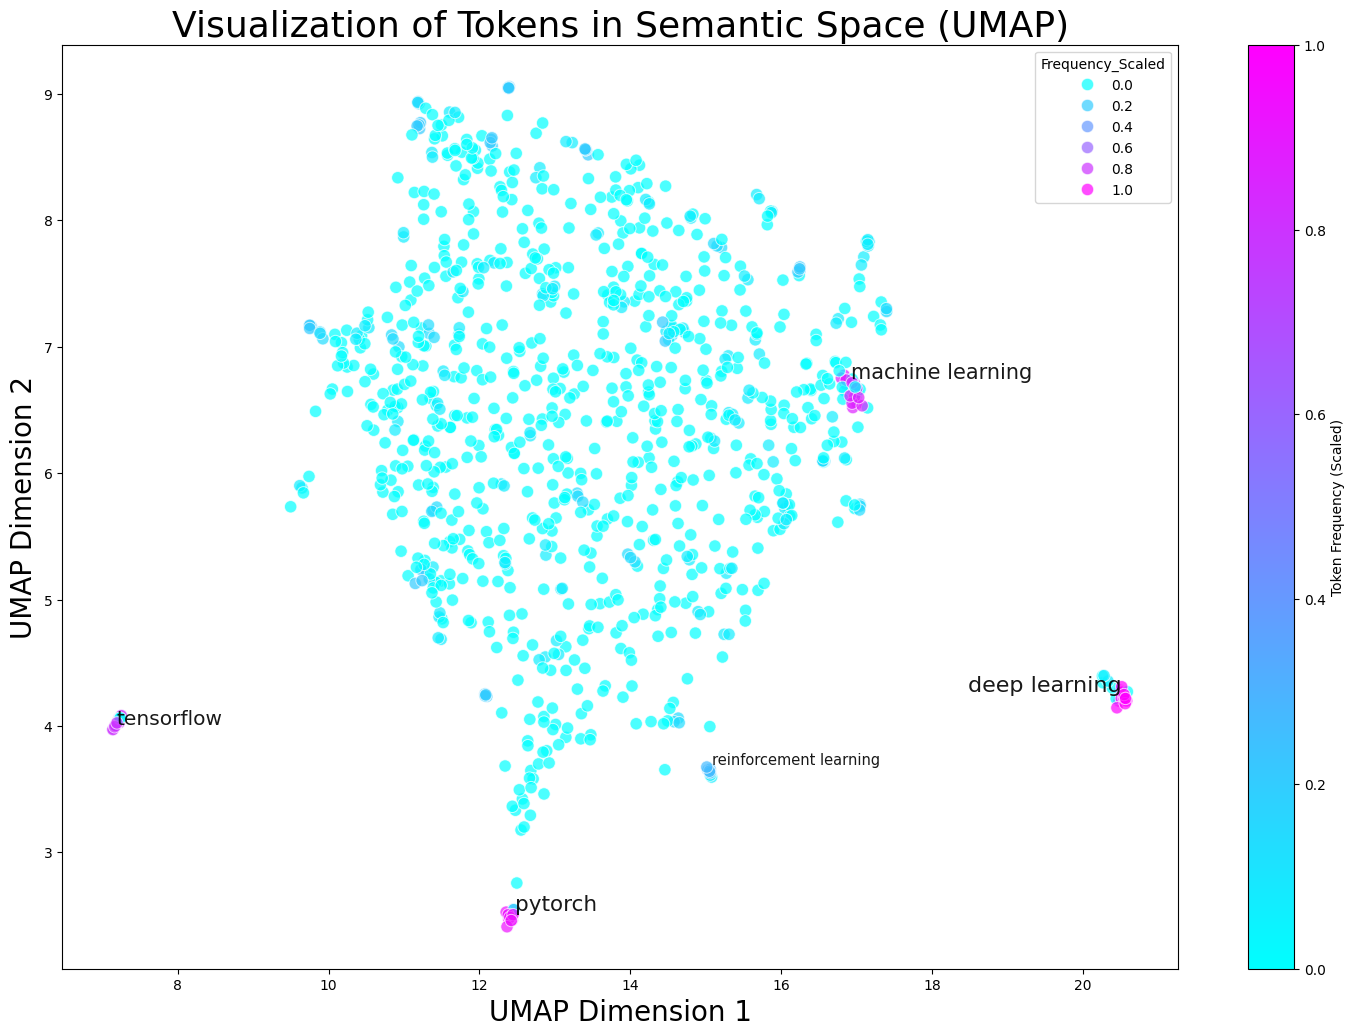

In [20]:

# ---- 1. דגימה של תתי-וקטורים ----
sample_size = 1000
sample_indices = random.sample(range(len(all_vectors)), min(sample_size, len(all_vectors)))
sampled_vectors = [all_vectors[i] for i in sample_indices]
sampled_tokens = [all_tokens[i] for i in sample_indices]

# ---- 2. הפחתת ממדים בעזרת UMAP ----
umap_reducer = umap.UMAP(n_neighbors=30, n_components=2, metric='cosine', random_state=42, min_dist=0.1)
reduced_embeddings = umap_reducer.fit_transform(sampled_vectors)

# ---- 3. הכנת הנתונים להצגה ----
embedding_df = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Token': sampled_tokens
})

# ---- 4. חישוב תדירות מילות מפתח ----
token_frequency = embedding_df['Token'].value_counts()
embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

# ---- 5. סינון מונחים לפי שכיחותם ----
threshold_frequency = 5  # הצגת מונחים שמופיעים לפחות מספר פעמים זה
filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

# ---- 6. נירמול התדירות בין 0 ל-1 ----
scaler = MinMaxScaler()
embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])

# ---- 7. הגדרות גרף ----
plt.figure(figsize=(18, 12))  # גודל גרף מותאם

# הגדרת הגרף עם ax
ax = sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='Frequency_Scaled',
    palette='cool',
    data=embedding_df,
    s=80,
    alpha=0.7
)

# הצגת מפת צבעים
norm = plt.Normalize(embedding_df['Frequency_Scaled'].min(), embedding_df['Frequency_Scaled'].max())
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Token Frequency (Scaled)', orientation='vertical')

# ---- 8. הוספת שמות המילים ----
previous_tokens = set()  # רשימה לשמירה על המילים שכבר הוצגו
texts = []  # רשימה של הטקסטים שמוסיפים לגרף
for i, row in filtered_df.iterrows():
    x, y = row['UMAP1'], row['UMAP2']
    token = row['Token']

    # אם המילה לא הופיעה לפני כן, הוסף לגרף
    if token not in previous_tokens:
        texts.append(plt.text(
            x,
            y,
            token,
            fontsize=min(20, 8 + row['Frequency'] / 2),
            alpha=0.9,
            weight='bold' if row['Frequency'] > 50 else 'normal'
        ))
        previous_tokens.add(token)

# התאמת המילים מבלי לחפוף אחת על השנייה
adjust_text(texts)

plt.title('Visualization of Tokens in Semantic Space (UMAP)', fontsize=26)
plt.xlabel('UMAP Dimension 1', fontsize=20)
plt.ylabel('UMAP Dimension 2', fontsize=20)
plt.show()


## Results Analysis with Precision, Recall, and F1 Score

In [ ]:
# clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)